In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.special import boxcox1p
from scipy.stats import norm,skew
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from scipy import stats
import warnings
import math
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from IPython.display import display

warnings.filterwarnings('ignore')
%matplotlib inline
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
#df_test.head()

In [2]:
target = df_train.SalePrice 

In [3]:
def scatterplot(df,varx,vary):
    #scatter plot grlivarea/saleprice
    data = pd.concat([df[varx], df[vary]], axis=1)
    data.plot.scatter(x=varx, y=vary);
    plt.show()
    
def plot_histogram(dataf , dofit=False):
    # Fit a normal distribution to the data:


    q25, q75 = np.nanpercentile(dataf, [25, 75])
    bin_width = 2 * (q75 - q25) * len(dataf.dropna()) ** (-1/3)
    bins = round((dataf.dropna().max() - dataf.dropna().min()) / bin_width)
    
    # Plot the histogram.
    plt.hist(dataf, bins=bins, density=True, alpha=0.6, color='g')
    plt.xlabel(dataf.name)
    plt.ylabel('count')
    # Plot the PDF.
    if dofit: 
        mu, std = norm.fit(dataf.dropna())
        xmin, xmax = plt.xlim()
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mu, std)

        plt.plot(x, p, 'k', linewidth=2)
        title = "Fit results: mean = %.2f,  std = %.2f" % (mu, std)
        plt.title(title)

    plt.show()
    
#Score

kfolds = KFold(n_splits=10, shuffle=True, random_state=42)
def rmse_cv_train(model,X_tr,y_tr):
    rmse= np.sqrt(-cross_val_score(model, X_tr, y_tr, scoring="neg_mean_squared_error",cv=kfolds))
    return(rmse)

def rmse_cv_test(model,X_te,y_te):
    rmse= np.sqrt(-cross_val_score(model, X_te, y_te,  scoring="neg_mean_squared_error",cv=kfolds))
    return(rmse)

# Explorando os dados

In [4]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [6]:
corr = df_train.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

##  Tratamento inicial

Lidando com valores nulos

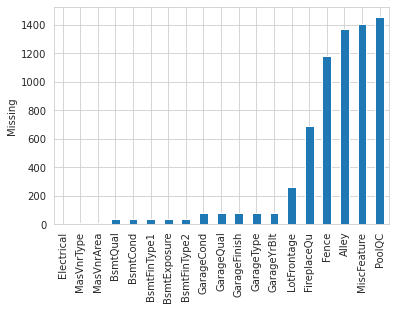

In [7]:
sns.set_style("whitegrid")
missing = df_train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()
plt.ylabel("Missing")
plt.show()

In [8]:
#O campo "id" não tem significado nenhum
df_train.drop(['Id'], axis=1, inplace=True)

# Alley : data description says NA means "no alley access"
# MasVnrType : NA most likely means no veneer
NA_to_none=["Alley","MasVnrType"]

for x in NA_to_none:
    df_train.loc[:, x] = df_train.loc[:, x].fillna("None")
    df_test.loc[:, x] = df_test.loc[:, x].fillna("None")

# BedroomAbvGr : NA most likely means 0
# EnclosedPorch : NA most likely means no enclosed porch
# HalfBath : NA most likely means no half baths above grade
# KitchenAbvGr : NA most likely means 0
# LotFrontage : NA most likely means no lot frontage
# OpenPorchSF : NA most likely means no open porch
# ScreenPorch : NA most likely means no screen porch
# TotRmsAbvGrd : NA most likely means 0

NA_to_0=["BedroomAbvGr","BsmtFullBath","BsmtHalfBath","BsmtUnfSF","Fireplaces","EnclosedPorch","GarageArea","GarageCars",
         "HalfBath","KitchenAbvGr","LotFrontage","MasVnrArea","MiscVal","OpenPorchSF","PoolArea","ScreenPorch","TotRmsAbvGrd",
         "WoodDeckSF"]
for x in NA_to_0:
    df_train.loc[:, x] = df_train.loc[:, x].fillna(0)
    df_test.loc[:, x] = df_test.loc[:, x].fillna(0)
    
    
# BsmtQual etc : data description says NA for basement features is "no basement"
NA_to_No= ["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1","BsmtFinType2","CentralAir","Fence","FireplaceQu",
           "GarageType","GarageFinish","GarageQual","GarageCond","MiscFeature","PavedDrive","PoolQC"]

for x in NA_to_No:
    df_train.loc[:, x] = df_train.loc[:, x].fillna("No")
    df_test.loc[:, x] = df_test.loc[:, x].fillna("No")

    
NA_to_Normal=["Condition1","Condition2","SaleCondition"]
for x in NA_to_Normal:
    df_train.loc[:, x] = df_train.loc[:, x].fillna("Normal")
    df_test.loc[:, x] = df_test.loc[:, x].fillna("Normal")
    
NA_to_TA=["ExterCond","ExterQual","HeatingQC","KitchenQual"]
for x in NA_to_TA:
    df_train.loc[:, x] = df_train.loc[:, x].fillna("TA")
    df_test.loc[:, x] = df_test.loc[:, x].fillna("TA")

# Functional : data description says NA means typical
df_train.loc[:, "Functional"] = df_train.loc[:, "Functional"].fillna("Typ")
df_test.loc[:, "Functional"] = df_test.loc[:, "Functional"].fillna("Typ")

# LotShape : NA most likely means regular
df_train.loc[:, "LotShape"] = df_train.loc[:, "LotShape"].fillna("Reg")
df_test.loc[:, "LotShape"] = df_test.loc[:, "LotShape"].fillna("Reg")

# Utilities : NA most likely means all public utilities
df_train.loc[:, "Utilities"] = df_train.loc[:, "Utilities"].fillna("AllPub")
df_test.loc[:, "Utilities"] = df_test.loc[:, "Utilities"].fillna("AllPub")

# Separando as features

In [9]:
categorical_features = df_train.select_dtypes(include = ["object"]).columns
numerical_features = df_train.select_dtypes(exclude = ["object"]).columns

train_num = df_train[numerical_features]
train_cat = df_train[categorical_features]

## Variáveis Categóricas

Separando variáveis numéricas de variáveis categóricas:

As variáveis categóricas são aquelas que apresentam um número limitado de valores possíveis, como em "PavedDrive":

**PavedDrive - se a entrada para a garagem é asfaltada**
>Y - asfaltada<br>
P - parcialmente asfaltada<br>
N - não asfaltada
   
Às vezes as categorias podem ser representadas por números, mas estes não têm sentido numérico, como em "OverallCond":

**OverallCond - avalia a condição geral da casa**
>10 - Muito Excelente<br>
9 - Excelente<br>
8 - Muito Bom<br>
7 - Bom<br>
6 - Acima da Média<br>
5 - Média<br>
4 - Abaixo da Média<br>
3 - Aceitável<br>
2 - Ruim<br>
1 - Muito Ruim

## Variáveis Numéricas

São aquelas que possuem valores numéricos e fazem sentido quantitativo, como "SalePrice":

## Transformação numérica de variáveis categóricas

Para que seja possível utilizar as variáveis categóricas na formação do modelo, é necessário primeiro transformá-las em números, técnica chamada *encoding*.

**One Hot Encoding** - utilizada geralmente em variáveis categóricas que não possuem ordem/ranking, ex:

Heating - type of heating
>Floor<br>
GasA<br>
GasW<br>
Grav<br>
OthW<br>
Wall

No One Hot Encoding a coluna que se procura converter é dividida em n colunas, em que n é o número de categorias da coluna original. Estas novas colunas são preenchidas somente com 1s e 0s.

**Ordinal Encoding** - utilizada quando a variável categórica apresenta ordem/ranking, ex:

HeatingQC - heating quality and condition

>Ex - Excellent<br>
Gd - Good<br>
TA - Average/Typical<br>
Fa - Fair<br>
Po - Poor

No Ordinal Encoding, cada valor (categoria) da coluna original é convertida em um número inteiro de 0 a n-1, onde n é o número de categorias.

In [10]:
# Criando "Dummy Features" para vaiáveis categóricas
print("NAs for categorical features in train : " + str(train_cat.isnull().values.sum()))
train_cat = pd.get_dummies(train_cat)
print("Remaining NAs for categorical features in train : " + str(train_cat.isnull().values.sum()))
train_cat.head(10)

NAs for categorical features in train : 1
Remaining NAs for categorical features in train : 0


,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_None,Alley_Pave,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,0,1,0,0,1,0,1,0,...,0,0,0,1,0,0,0,0,1,0
1,0,0,0,1,0,0,1,0,1,0,...,0,0,0,1,0,0,0,0,1,0
2,0,0,0,1,0,0,1,0,1,0,...,0,0,0,1,0,0,0,0,1,0
3,0,0,0,1,0,0,1,0,1,0,...,0,0,0,1,1,0,0,0,0,0
4,0,0,0,1,0,0,1,0,1,0,...,0,0,0,1,0,0,0,0,1,0
5,0,0,0,1,0,0,1,0,1,0,...,0,0,0,1,0,0,0,0,1,0
6,0,0,0,1,0,0,1,0,1,0,...,0,0,0,1,0,0,0,0,1,0
7,0,0,0,1,0,0,1,0,1,0,...,0,0,0,1,0,0,0,0,1,0
8,0,0,0,0,1,0,1,0,1,0,...,0,0,0,1,1,0,0,0,0,0
9,0,0,0,1,0,0,1,0,1,0,...,0,0,0,1,0,0,0,0,1,0


In [11]:
# Substituindo os valores que faltam pela mediana
print("NAs for numerical features in train : " + str(train_num.isnull().values.sum()))
train_num = train_num.fillna(train_num.median())
print("Remaining NAs for numerical features in train : " + str(train_num.isnull().values.sum()))

NAs for numerical features in train : 81
Remaining NAs for numerical features in train : 0


In [12]:
train1 = pd.concat([train_num, train_cat], axis = 1)
features = train1.columns.drop("SalePrice") #No final o preço de venda deverá ser separado das features para fazer a
                      

## Observações iniciais

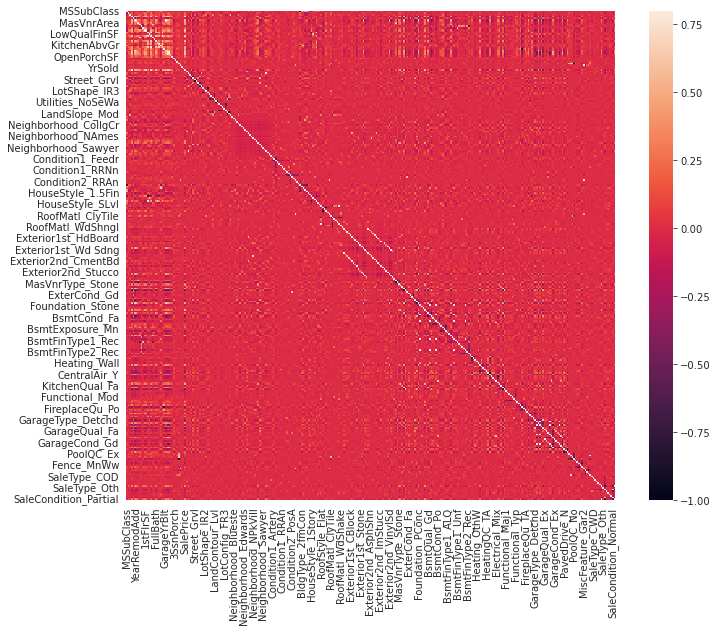

In [13]:
corrmat = train1.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

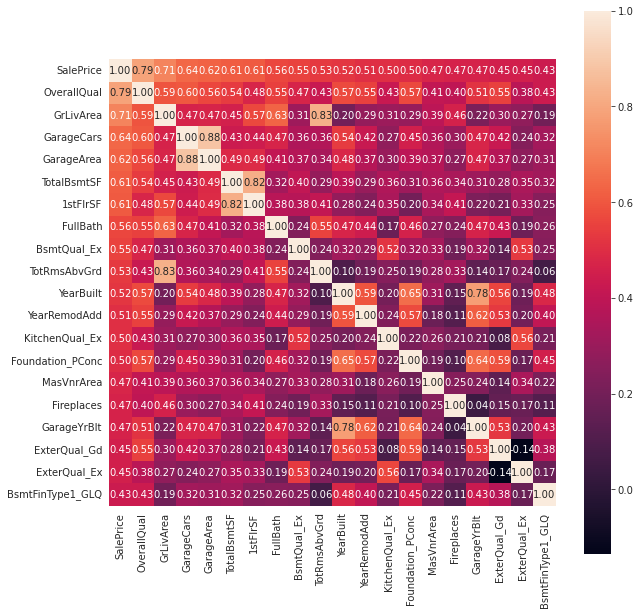

In [14]:
#Features com mais correlação com o SalePrice
k = 20 
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train1[cols].values.T)
#sns.set(font_scale=1.25)
fig, ax = plt.subplots(figsize=(10,10))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Outras variáveis com alta correlação entre si: <br>

TotalBsmtSF e 1stFlrSF<br>
TotRmsAbvGrd e GrLivArea<br>
GarageCars e GarageArea<br>
YearBuilt e GarageYrBlt<br>

Foundation_PConc, YearBuilt, GarageYrBlt<br>
GrLivArea e FullBath <br>

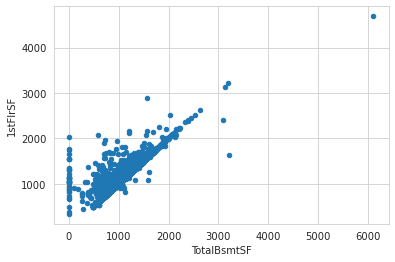

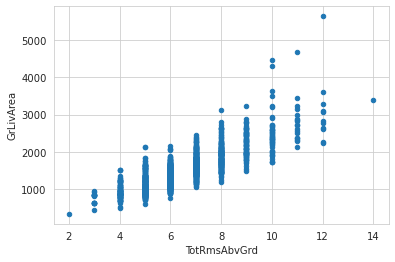

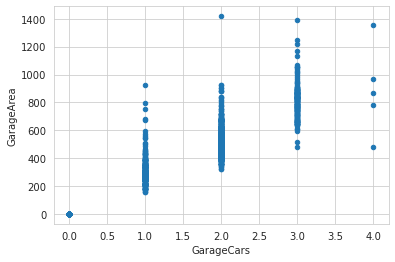

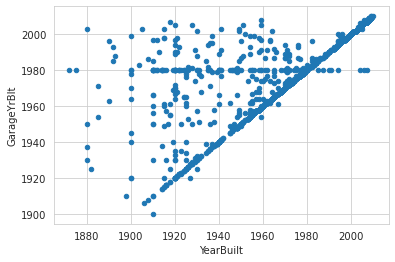

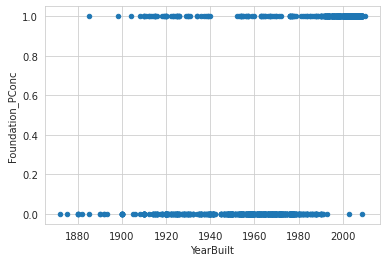

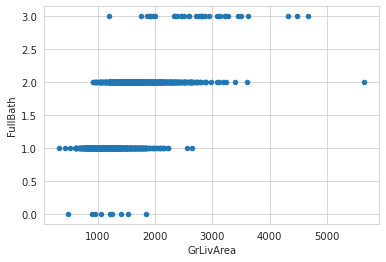

In [15]:
scatterplot(train1,"TotalBsmtSF",  "1stFlrSF")
scatterplot(train1,"TotRmsAbvGrd",  "GrLivArea")
scatterplot(train1,"GarageCars",  "GarageArea")
scatterplot(train1,"YearBuilt",  "GarageYrBlt")

scatterplot(train1,"YearBuilt",  "Foundation_PConc")
scatterplot(train1,"GrLivArea",  "FullBath")

## $1^{a}$ Regressão

In [16]:
lr = LinearRegression()
#X_train, X_test, y_train, y_test = train_test_split(train, target, test_size = 0.1, random_state = 0)
y_train=target
X_train=train1[features]
print(X_train.shape)
print(y_train.shape)
lr = LinearRegression()
lr.fit(X_train, y_train)

(1460, 301)
(1460,)


LinearRegression()

### Distribuição dos erros

In [17]:
y_train_pred = lr.predict(X_train)
error = y_train_pred - y_train

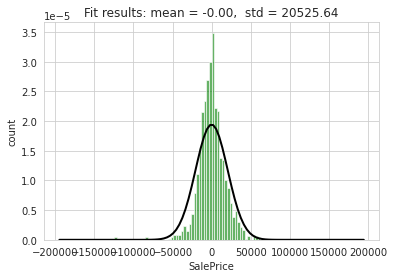

R2score: 0.933198674872362


count    1.460000e+03
mean    -5.980239e-12
std      2.053267e+04
min     -1.769931e+05
25%     -9.607436e+03
50%     -1.165405e-06
75%      9.064987e+03
max      1.769931e+05
Name: SalePrice, dtype: float64

In [18]:
plot_histogram(error, dofit=True)
print("R2score: "+ str(lr.score(X_train, y_train)))
#print("RMSE on Training set :", rmse_cv_train(lr).mean())
error.describe()
#print("RMSE on Test set :", rmse_cv_test(lr).mean())

# Retornando para os dados

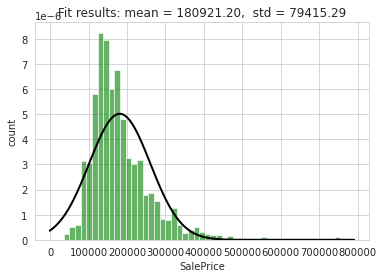

In [19]:
plot_histogram(df_train["SalePrice"],dofit =True)

### Função logarítimo

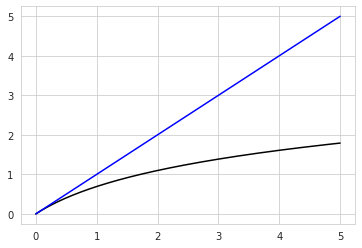

In [20]:
xl=np.linspace(0,5,300)
ylog=np.log1p(xl)# log(1+x)
plt.plot(xl,ylog,"k-",xl,xl,"b-")
plt.show()

A função Logarítimo tende a diminuir aumentar os valores próximos da origem e diminuir os valores que estão longe

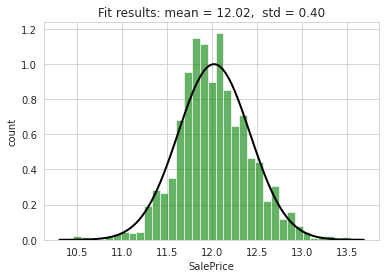

In [21]:
logSalePrice=np.log1p(df_train["SalePrice"])
plot_histogram(logSalePrice, dofit = True)

In [22]:
target = logSalePrice

## $2^a$ Regressão

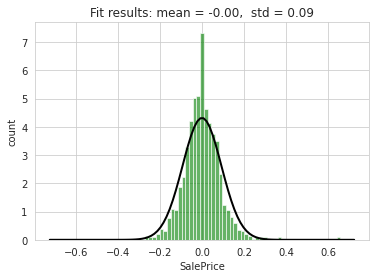

R2score: 0.9473006130827539
RMSE on Training set : 0.14806466478017308
RMSE on Validation set : 0.2533185561310117


count    1.314000e+03
mean    -3.149856e-16
std      9.241917e-02
min     -6.576929e-01
25%     -5.023837e-02
50%     -1.128018e-03
75%      4.613660e-02
max      6.576929e-01
Name: SalePrice, dtype: float64

In [23]:
lr = LinearRegression()
X_train, X_valid, y_train, y_valid = train_test_split(train1[features], target, test_size = 0.1, random_state = 0)


lr = LinearRegression()
lr.fit(X_train, y_train)
y_train_pred = lr.predict(X_train)
y_valid_pred = lr.predict(X_valid)
error = y_train_pred - y_train
#error = y_train_pred - y
plot_histogram(error,dofit= True)
print("R2score: "+ str(lr.score(X_train, y_train)))

print("RMSE on Training set :", rmse_cv_train(lr,X_train,y_train).mean())
print("RMSE on Validation set :", rmse_cv_test(lr,X_valid,y_valid).mean())
error.describe()

In [24]:
categorical_features = df_test.select_dtypes(include = ["object"]).columns
numerical_features = df_test.select_dtypes(exclude = ["object"]).columns

testids=df_test["Id"]
tst_num = df_test[numerical_features.drop("Id")]
tst_cat = df_test[categorical_features]


tst_cat = pd.get_dummies(tst_cat)
tst_num = tst_num.fillna(tst_num.median())


tst=pd.concat([tst_num, tst_cat], axis = 1)
li= [x for x in X_train.columns if (x not in tst.columns)]

for x in li:
    tst[x]=0

    
pred1=lr.predict(tst)

#pred1=pd.DataFrame(y_train_pred)
#pred1.name="sales"

#pred1.describe()

In [25]:
rslt=pd.DataFrame(testids)
rslt["SalePrice"]=np.exp(pred1)
rslt.describe()

,Id,SalePrice
count,1459.000000,1459.000000
mean,2190.000000,33145.134755
std,421.321334,17275.146260
min,1461.000000,1986.769870
25%,1825.500000,22137.598883
50%,2190.000000,30002.254167
75%,2554.500000,39349.066573
max,2919.000000,299490.483140


In [26]:
np.exp(target).describe()

count      1460.000000
mean     180922.195890
std       79442.502883
min       34901.000000
25%      129976.000000
50%      163001.000000
75%      214001.000000
max      755001.000000
Name: SalePrice, dtype: float64

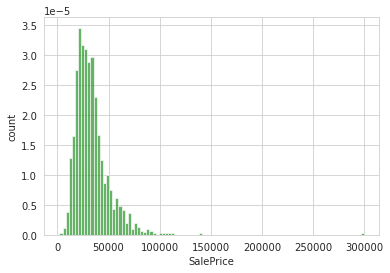

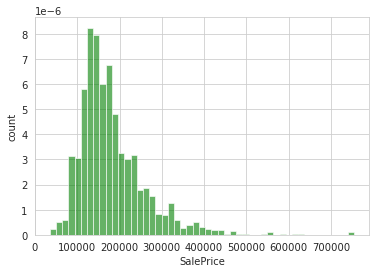

In [27]:
plot_histogram(rslt["SalePrice"])
plt.show()
plot_histogram(np.exp(target))
plt.show()

In [28]:
#rslt.to_csv("./result0(b4treat).csv",index=False)

# Corrigindo o encoding das features:

<font size="+0.5">Algumas features relacionadas à qualidade ou condição da casa foram anteriormente agrupadas como features categóricas, mas elas podem ser convertidas para números (ordinal encoding)</font>


### Foundation

Distribuição das casas com todos os tipos de fundação:


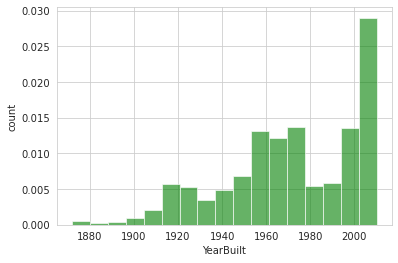

Distribuição das casas com fundação de concreto:


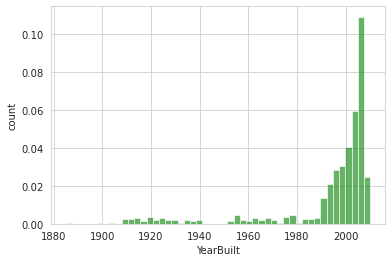

Distribuição das casas com outros tipos Fundação (excluindo concreto):


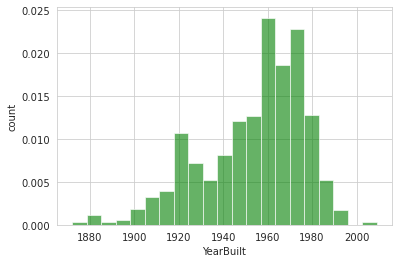

In [29]:
#Separando somente as casas com fundação de concreto das que não tem fundação de concreto
onlyconcfound = train1[train1.Foundation_PConc == 1]
onlynonconcfound = train1[train1.Foundation_PConc != 1]

print("Distribuição das casas com todos os tipos de fundação:")
plot_histogram(train1["YearBuilt"])
print("Distribuição das casas com fundação de concreto:")
plot_histogram(onlyconcfound["YearBuilt"])
print("Distribuição das casas com outros tipos Fundação (excluindo concreto):")
plot_histogram(onlynonconcfound["YearBuilt"])

As casas com fundação de concreto são, no geral, mais recentes

Todas as casas:


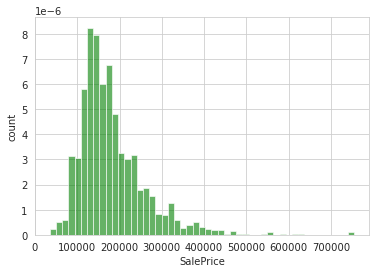

valor médio total: 180921.19589041095

Casas com fundação de concreto:


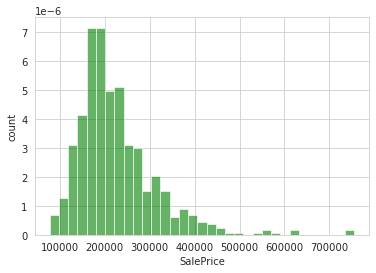

valor médio c/ fund de concreto: 225230.44204018547
diferênça (%): 24.49090938831395

Casas com outros tipos de fundação:


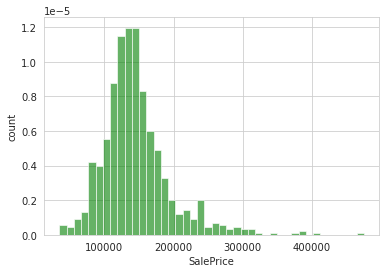

valor médio c/ fund de concreto: 145659.1020910209
diferênça (%): -19.49030550336915



In [30]:
# comparando a média dos preços de venda das casas com fundação de concreto com a médida de preço
#do resto das casas

#todas as casas:
print("Todas as casas:")
plot_histogram(df_train["SalePrice"])
totmed=df_train["SalePrice"].mean()
print("valor médio total: "+ str(totmed) +"\n")

#apenas as que tem fundação de concreto:
print("Casas com fundação de concreto:")
plot_histogram(onlyconcfound["SalePrice"])
concmed=onlyconcfound["SalePrice"].mean()
difconc=((concmed- totmed)/totmed)*100
print("valor médio c/ fund de concreto: "+ str(concmed))
print("diferênça (%): " + str( difconc )+"\n")

#apenas as que não tem fundação de concreto
print("Casas com outros tipos de fundação:")
plot_histogram(onlynonconcfound["SalePrice"])
nonconcmed=onlynonconcfound["SalePrice"].mean()
difnonconc=((nonconcmed- totmed)/totmed)*100
print("valor médio c/ fund de concreto: "+ str(nonconcmed))
print("diferênça (%): " + str( difnonconc )+"\n")

<AxesSubplot:xlabel='Foundation', ylabel='SalePrice'>

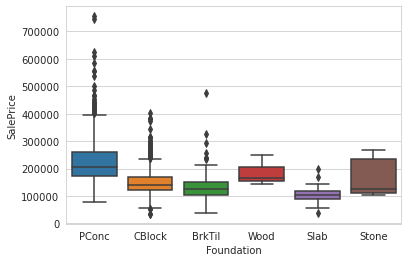

In [31]:
sns.boxplot(x=df_train["Foundation"],y=df_train["SalePrice"])

<font size="+0.5">O tipo de fundação pode ter um impacto no preço da casa. Isso sugere que podemos talvez tentar dar um valor numérico para cada tipo de fundação <br>
Ordem de valor médio: "Slab" = 1, "BrkTil" = 2, "CBlock" = 3, "Stone"= 4, "Wood"= 5, "PConc"= 6 </font>


### Neighborhood

<AxesSubplot:xlabel='Neighborhood', ylabel='SalePrice'>

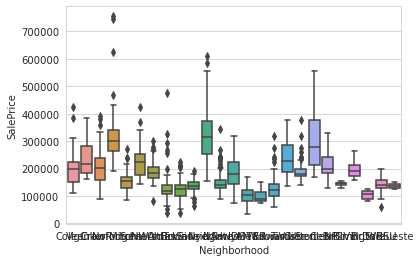

In [32]:
sns.boxplot(x=df_train["Neighborhood"],y=df_train["SalePrice"])

In [33]:

NBordering = pd.DataFrame()
NBordering['val'] = df_train["Neighborhood"].unique()
NBordering.index = NBordering.val
NBordering['meanSPrice'] = df_train[["Neighborhood", 'SalePrice']].groupby("Neighborhood").mean()['SalePrice']
NBordering = NBordering.sort_values('meanSPrice')
NBordering['ordering'] = range(1, NBordering.shape[0]+1)
NBordering = NBordering['ordering'].to_dict()
    
print(NBordering)
    


{'MeadowV': 1, 'IDOTRR': 2, 'BrDale': 3, 'BrkSide': 4, 'Edwards': 5, 'OldTown': 6, 'Sawyer': 7, 'Blueste': 8, 'SWISU': 9, 'NPkVill': 10, 'NAmes': 11, 'Mitchel': 12, 'SawyerW': 13, 'NWAmes': 14, 'Gilbert': 15, 'Blmngtn': 16, 'CollgCr': 17, 'Crawfor': 18, 'ClearCr': 19, 'Somerst': 20, 'Veenker': 21, 'Timber': 22, 'StoneBr': 23, 'NridgHt': 24, 'NoRidge': 25}


<font size="+0.5">Muitas features relacionadas à qualidade da casa estão passando pelo One Hot Encoding, quando deveriam ser tratadas com o Ordinal Encoding:</font>

In [34]:
quality_features = {"Alley" : {"Grvl" : 1, "Pave" : 2},
                       "BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       
                       #O número adicionado aqui depende da média do preço das casas de cada categoria
                       "Neighborhood" : NBordering,
                       "Foundation" : {"Slab" : 1, "BrkTil" : 2, "CBlock" : 3, "Stone": 4, "Wood": 5, "PConc": 6},
                       
                       
                       "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Street" : {"Grvl" : 1, "Pave" : 2},
                       #"Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}
                       }

df_train = df_train.replace(quality_features)
df_test = df_test.replace(quality_features)

numerical_categories = {"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                      }
df_train = df_train.replace(numerical_categories)
df_test = df_test.replace(numerical_categories)

### Foundation

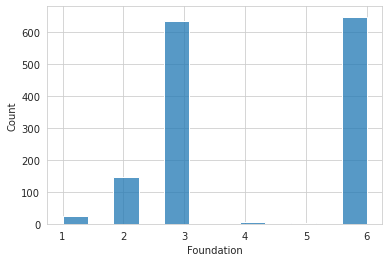

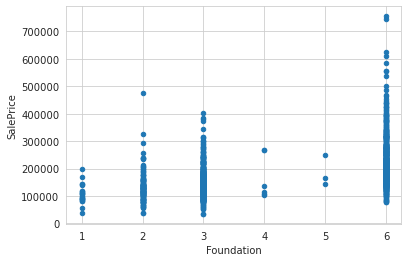

In [35]:
sns.histplot(df_train["Foundation"])
scatterplot(df_train, "Foundation","SalePrice")

### Neighborhood

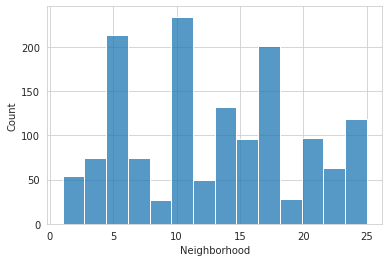

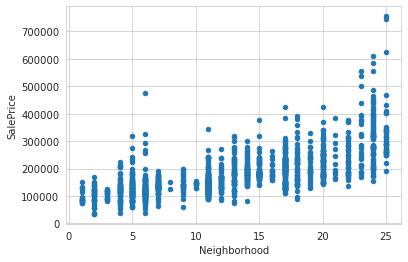

In [36]:
sns.histplot(df_train["Neighborhood"])
scatterplot(df_train, "Neighborhood","SalePrice")

### Bsmt

<AxesSubplot:xlabel='BsmtQual', ylabel='Count'>

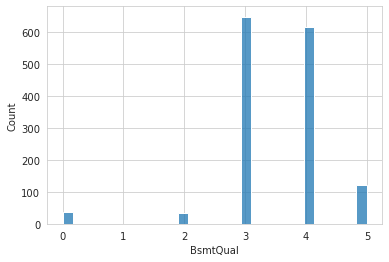

In [37]:
sns.histplot(df_train["BsmtQual"])

Em geral, como o custo de uma casa é bastante alto então as casas de qualidade muito baixa provavelmente não chegam a ser vendidas, como o dataset trata somente das casas que foram vendidas é de se esperar que as features de qualidade dessas casas estejam. Talvez não devessemos esperar que essas features de qualidade sigam a distribuição normal

In [38]:
corr = df_train.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice.head(20))

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
Neighborhood    0.696882
ExterQual       0.682639
KitchenQual     0.659600
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
BsmtQual        0.585207
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
FireplaceQu     0.520438
YearRemodAdd    0.507101
Foundation      0.505503
GarageYrBlt     0.486362
MasVnrArea      0.472614
Fireplaces      0.466929
Name: SalePrice, dtype: float64


## Separando novamente as features categóricas das features numéricas

In [39]:
categorical_features = df_train.select_dtypes(include = ["object"]).columns
categorical_featuressp=categorical_features.tolist()+["SalePrice"]
numerical_features = df_train.select_dtypes(exclude = ["object"]).columns

testids=df_test["Id"]
test_num=df_test[numerical_features.drop("SalePrice")]
test_cat=df_test[categorical_features]

train_num = df_train[numerical_features]
train_cat = df_train[categorical_features]
#train_catsp = df_train[categorical_featuressp]

# Introdução de novas features

In [40]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

In [41]:
print(get_top_abs_correlations(train_num, 20))

GarageQual    GarageCond      0.959172
PoolArea      PoolQC          0.899924
GarageCars    GarageArea      0.882475
Fireplaces    FireplaceQu     0.863241
YearBuilt     GarageYrBlt     0.825667
GrLivArea     TotRmsAbvGrd    0.825489
TotalBsmtSF   1stFlrSF        0.819530
OverallQual   SalePrice       0.790982
BsmtFinType2  BsmtFinSF2      0.788986
OverallQual   ExterQual       0.726278
ExterQual     KitchenQual     0.716122
GrLivArea     SalePrice       0.708624
Neighborhood  SalePrice       0.696882
BsmtFinType1  BsmtFinSF1      0.695751
YearBuilt     Foundation      0.694441
2ndFlrSF      GrLivArea       0.687501
ExterQual     SalePrice       0.682639
Foundation    GarageYrBlt     0.679975
BedroomAbvGr  TotRmsAbvGrd    0.676620
Neighborhood  YearBuilt       0.675780
dtype: float64


## Score features

In [42]:
scorefeatures={"OverallScore":["OverallQual","OverallCond"],
                 "PoolScore":["PoolArea","PoolQC"],
                 "GarageScore":["GarageArea","GarageCond","GarageQual"],
                 "ExterScore":["ExterQual","ExterCond"],
                 "KitchenScore":["KitchenAbvGr","KitchenQual"]}
for sf, feats in scorefeatures.items():
    prodtrain=1
    prodtest=1
    for feat in feats:
        prodtrain=prodtrain*train_num[feat]
        prodtest=prodtest*test_num[feat]
    train_num[sf]=prodtrain
    test_num[sf]=prodtest


### Analisando as distribuições e correlações entre as variáveis numéricas 

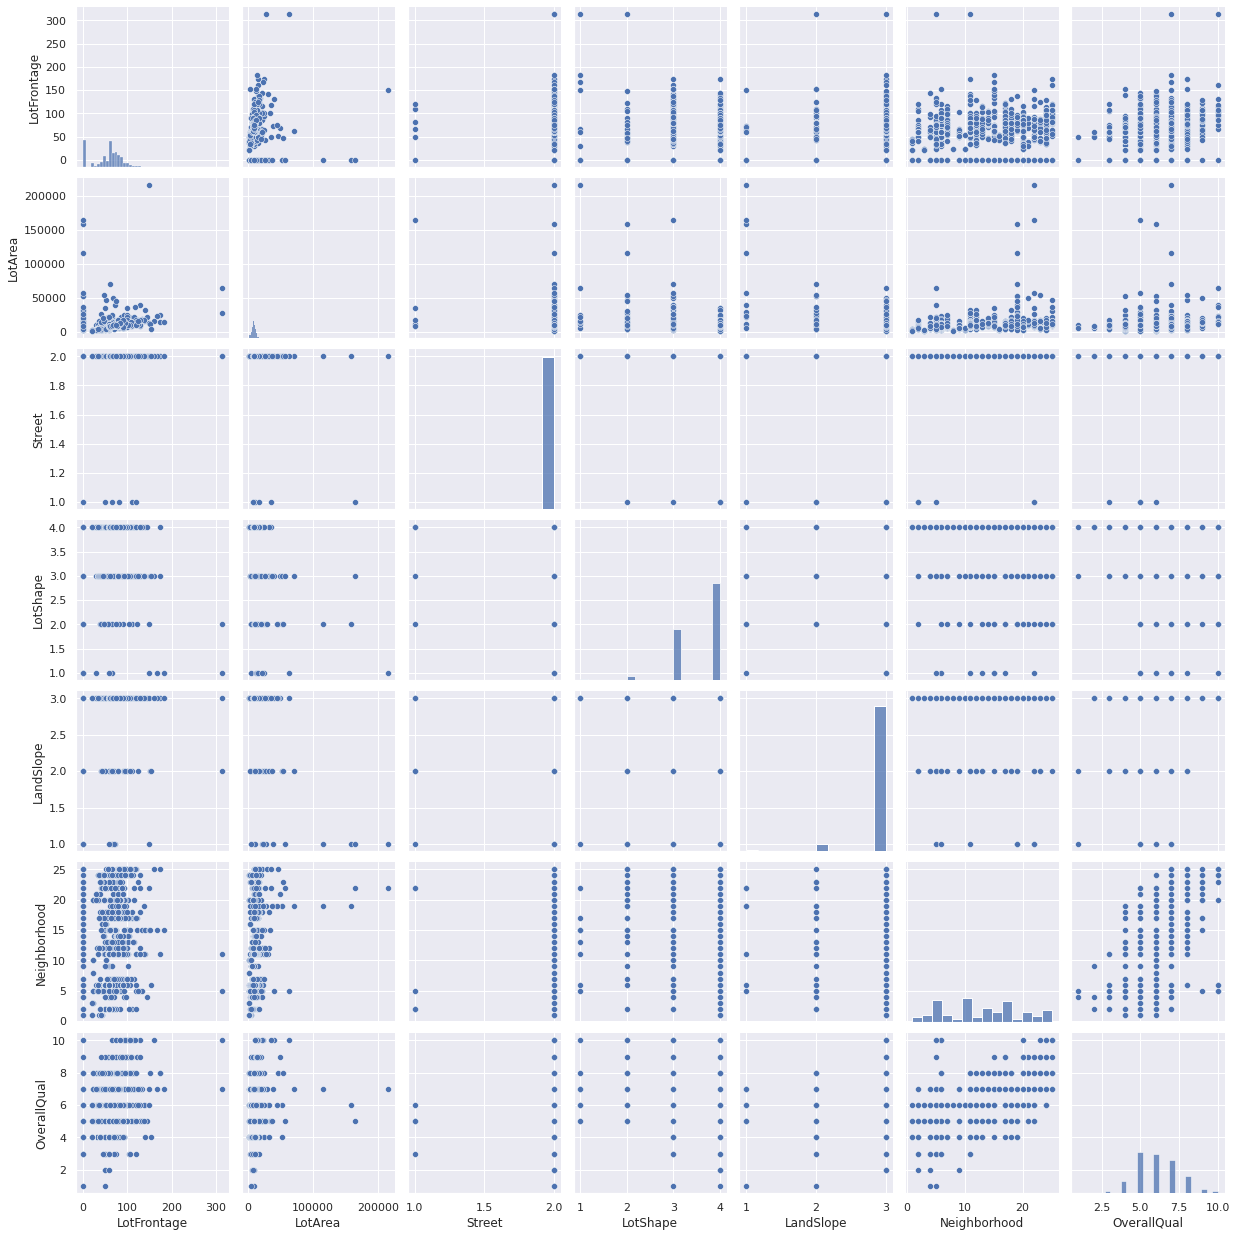

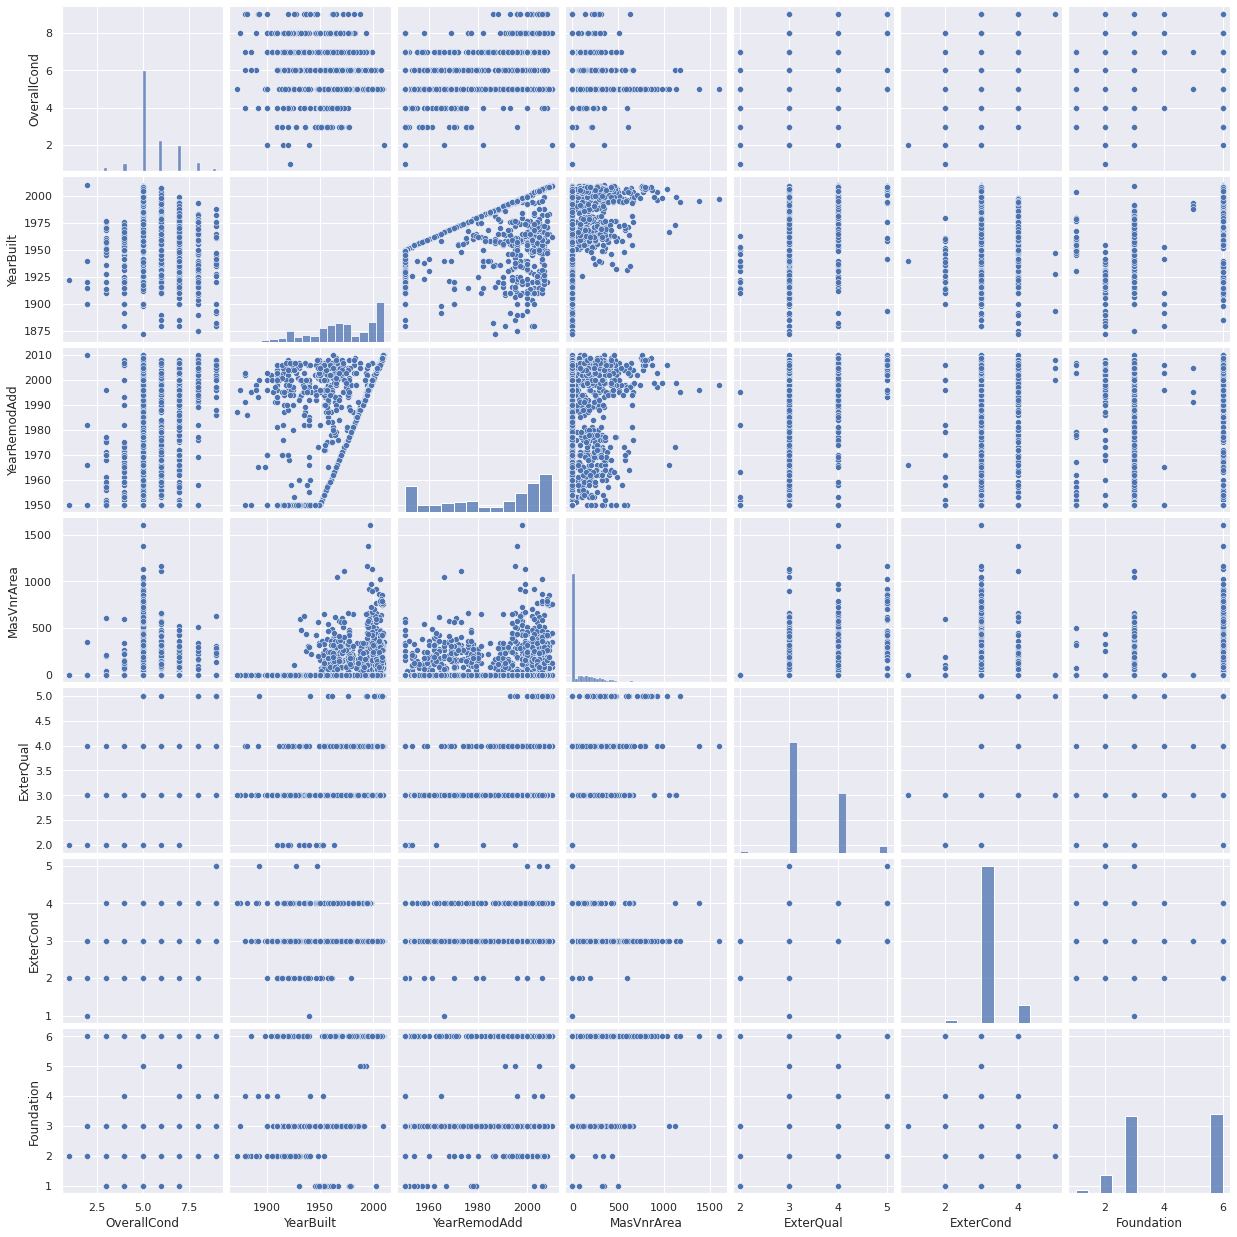

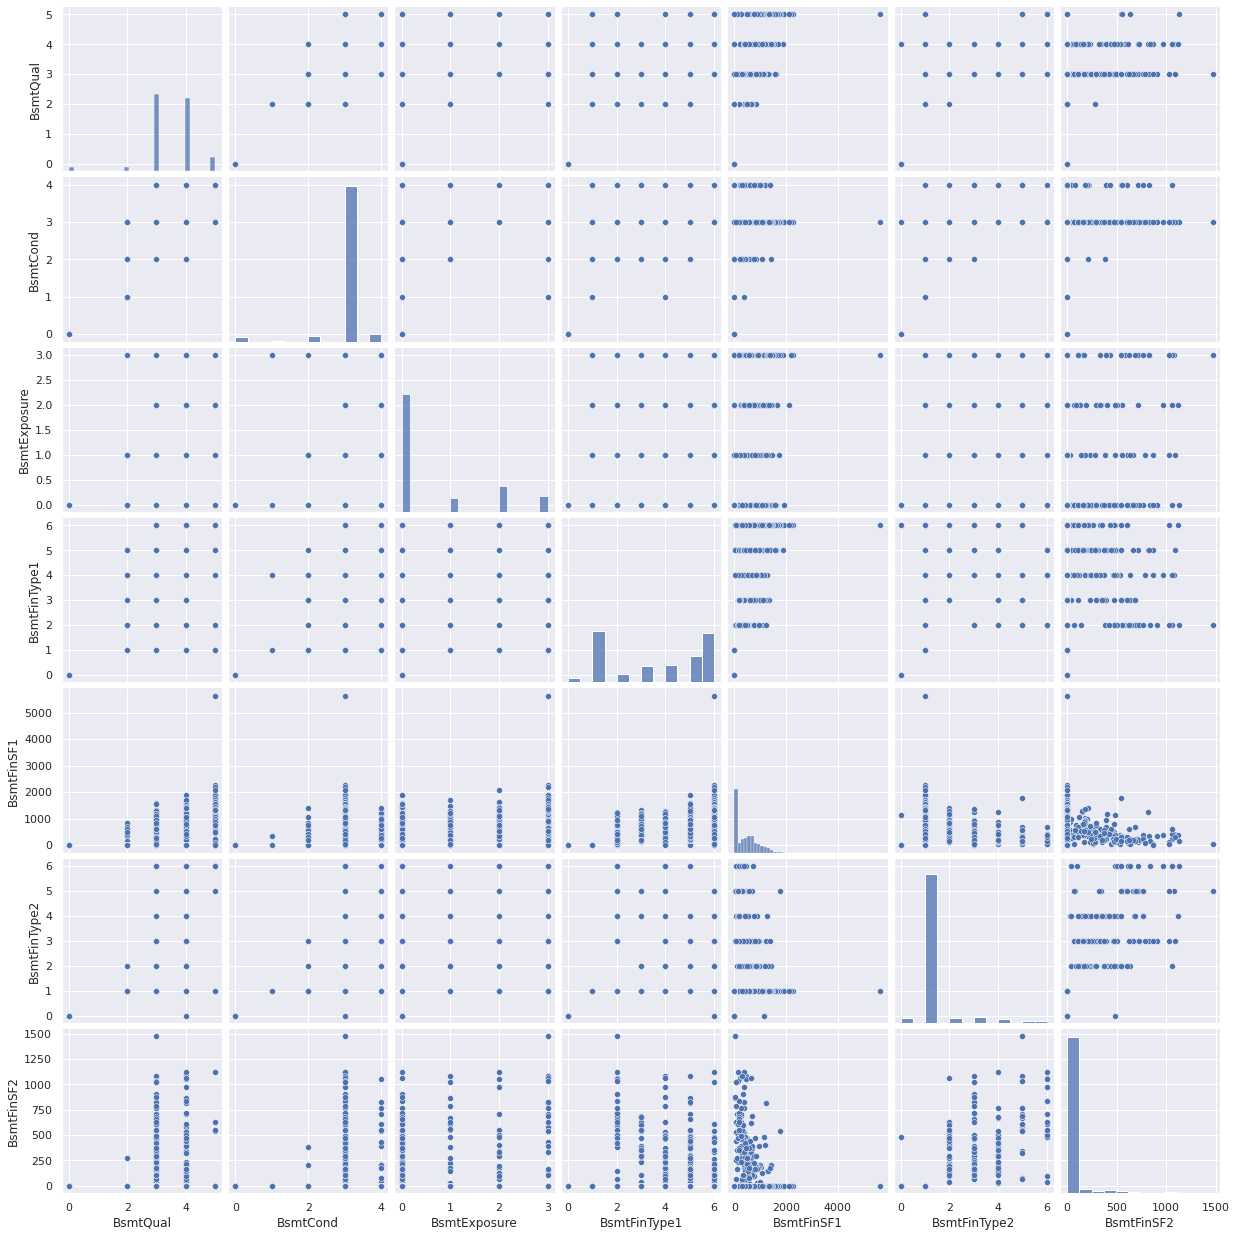

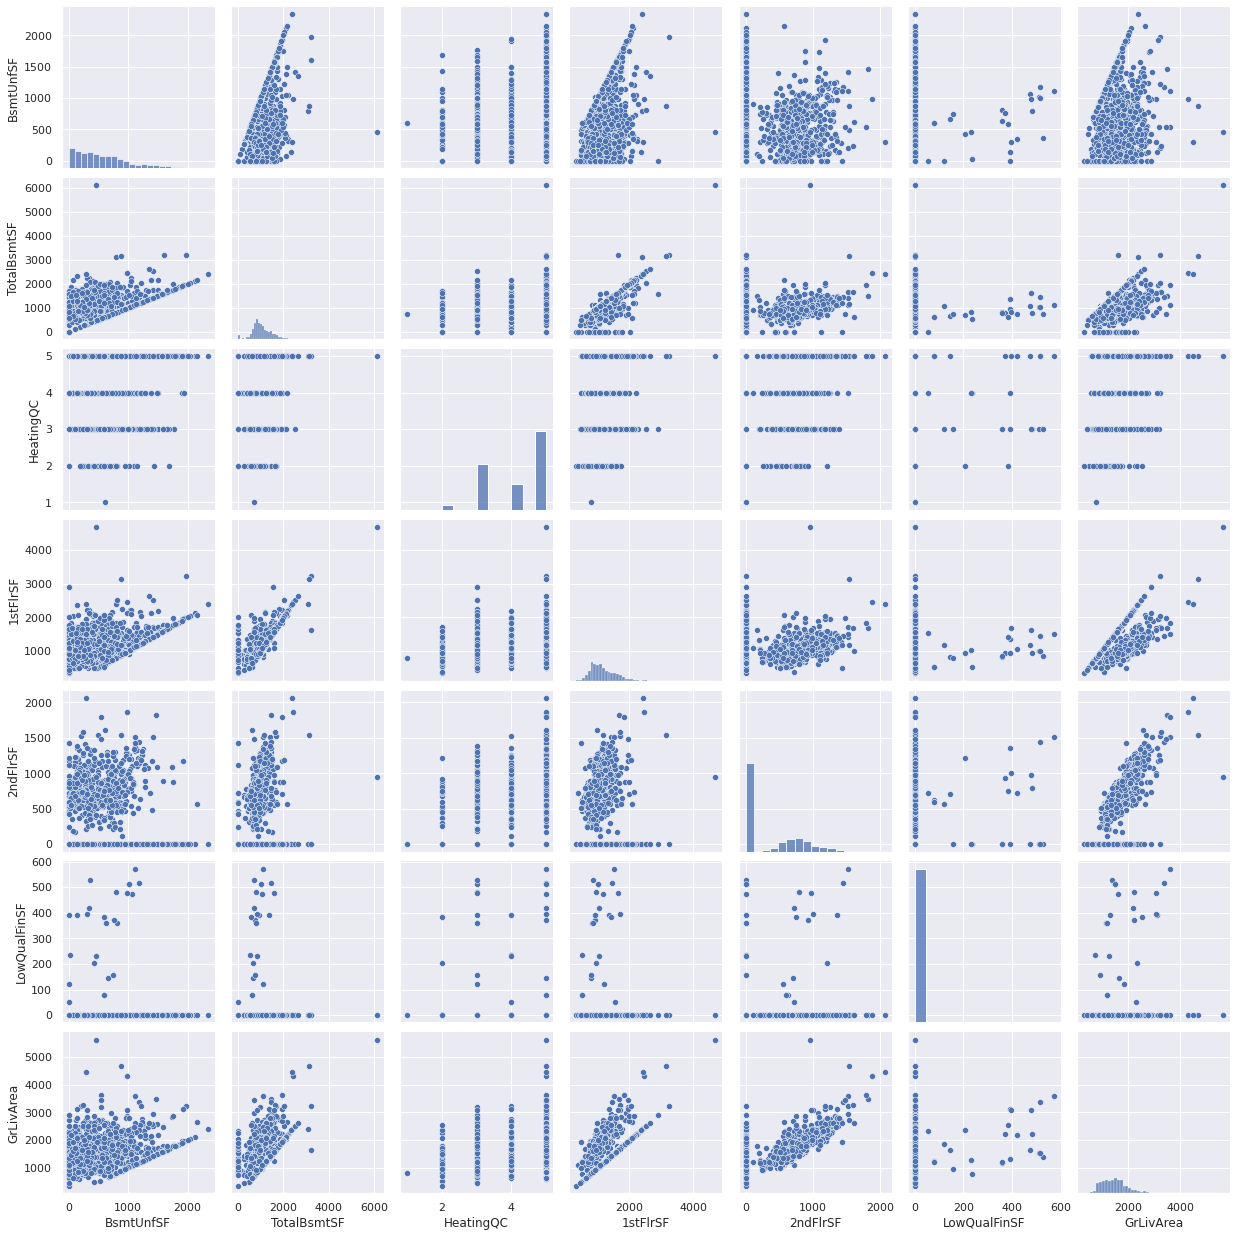

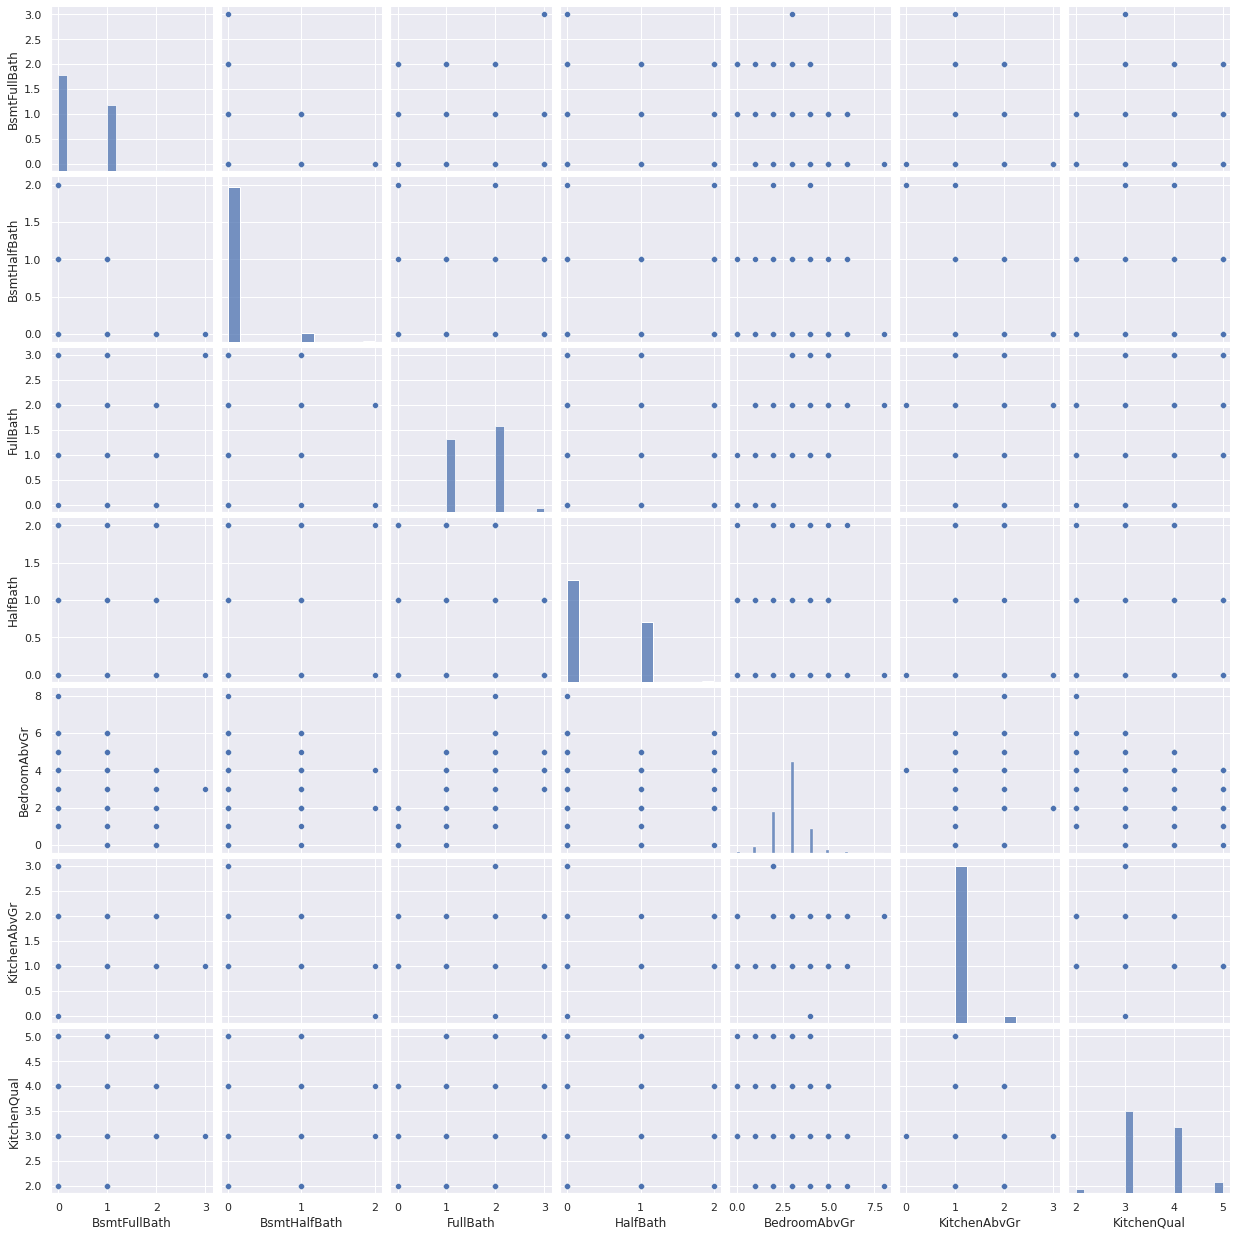

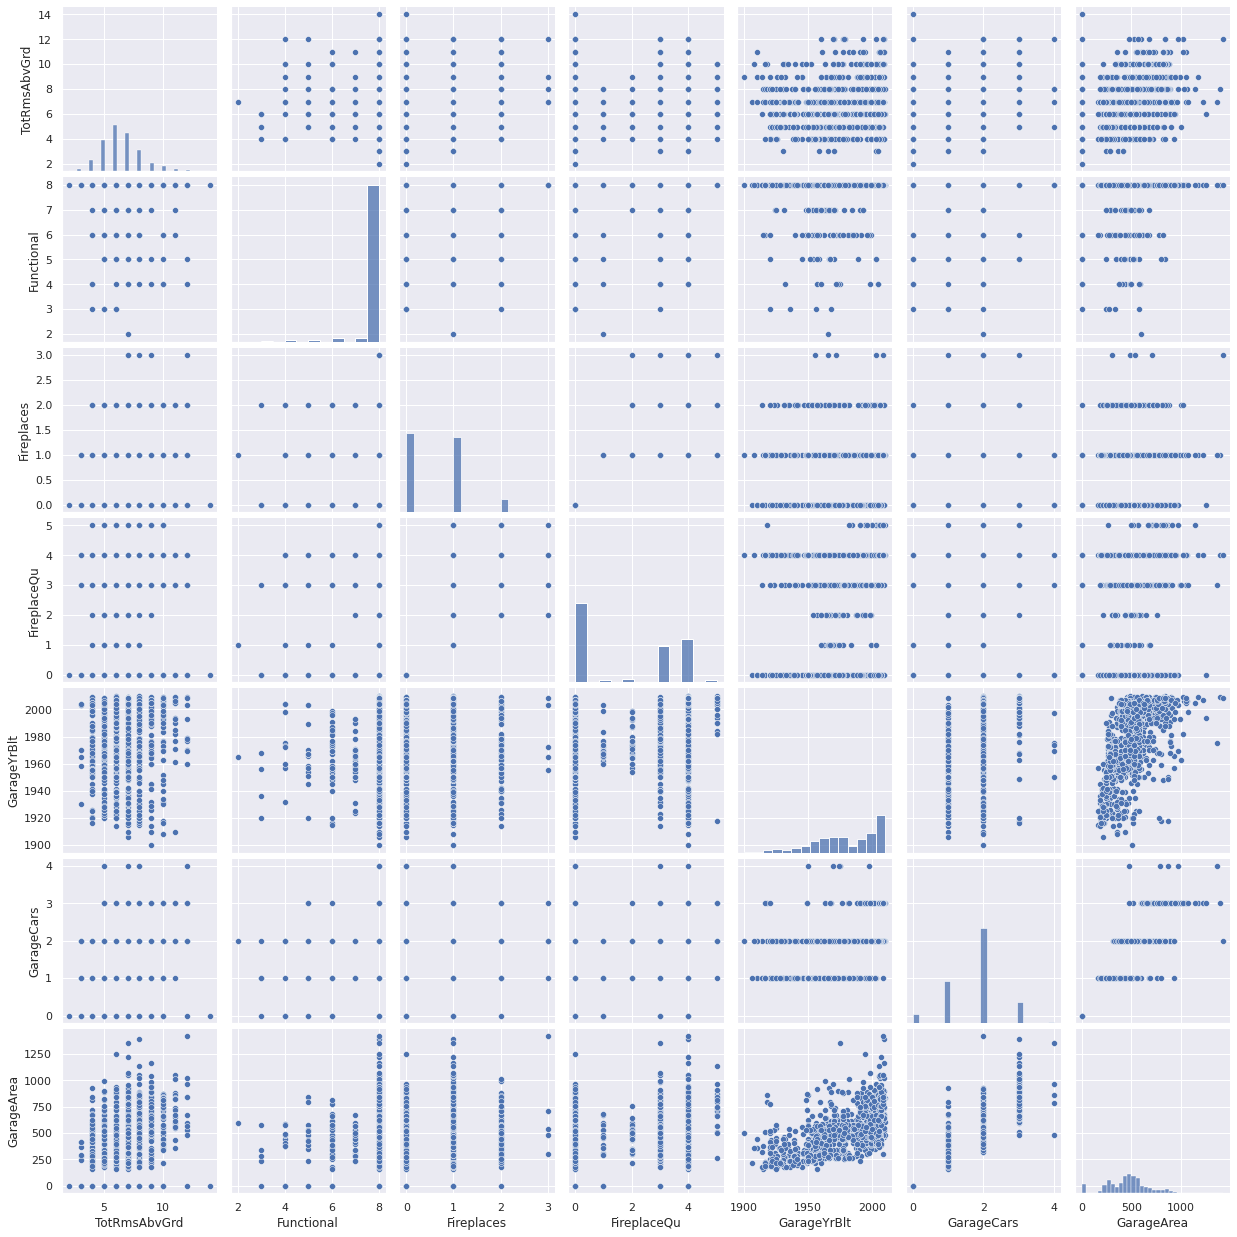

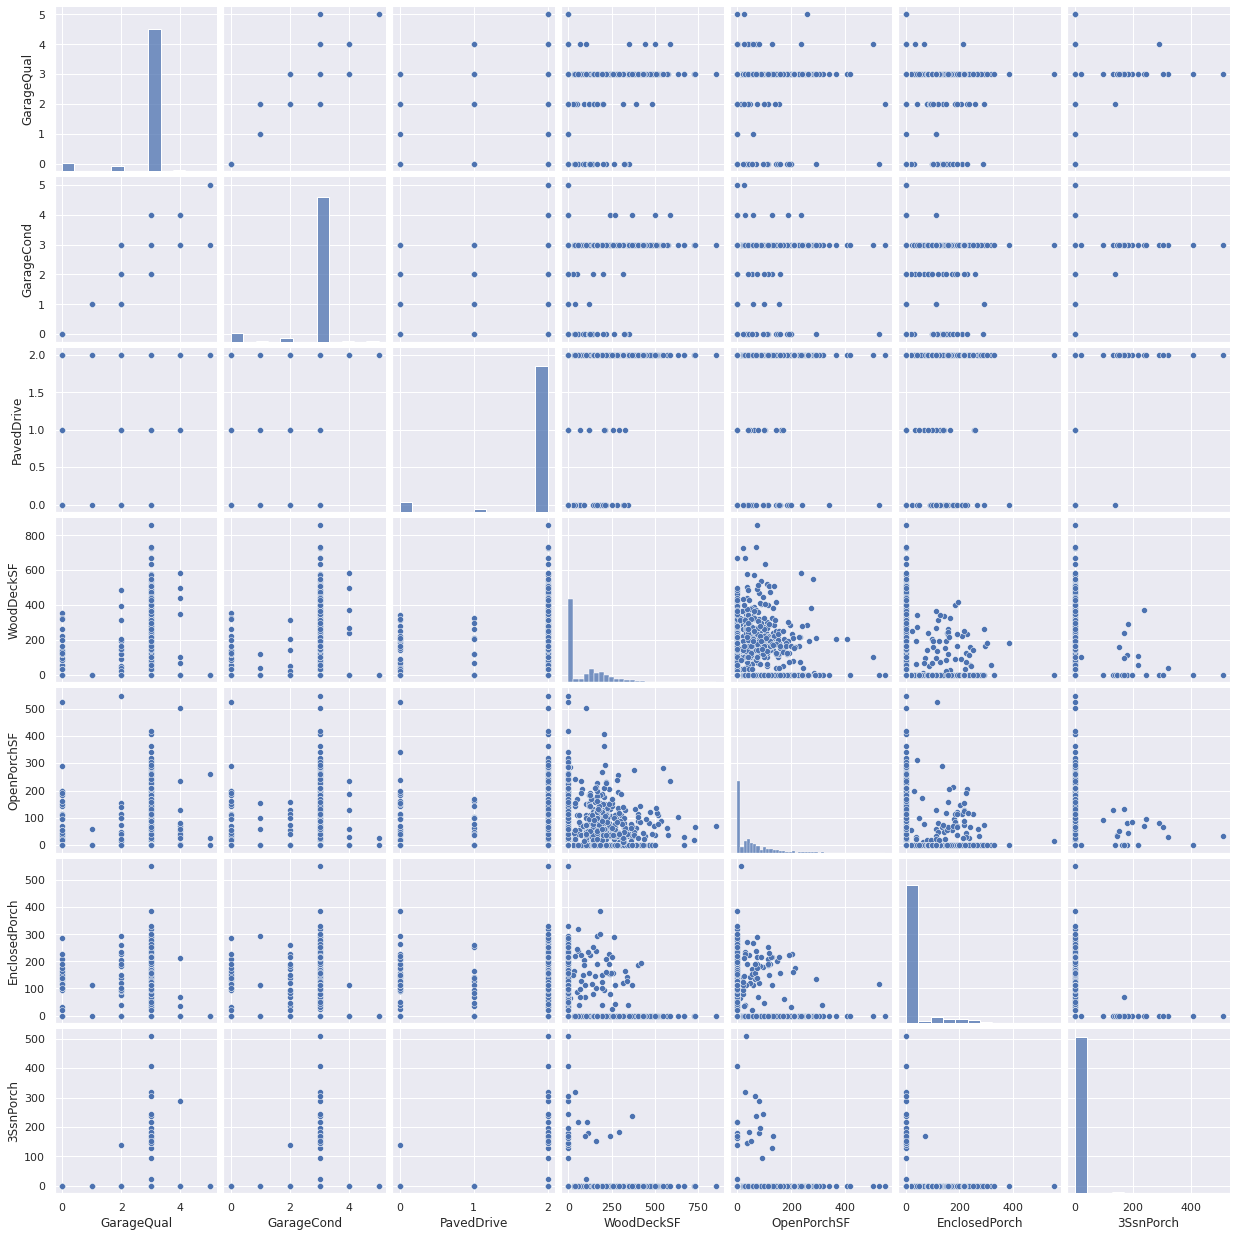

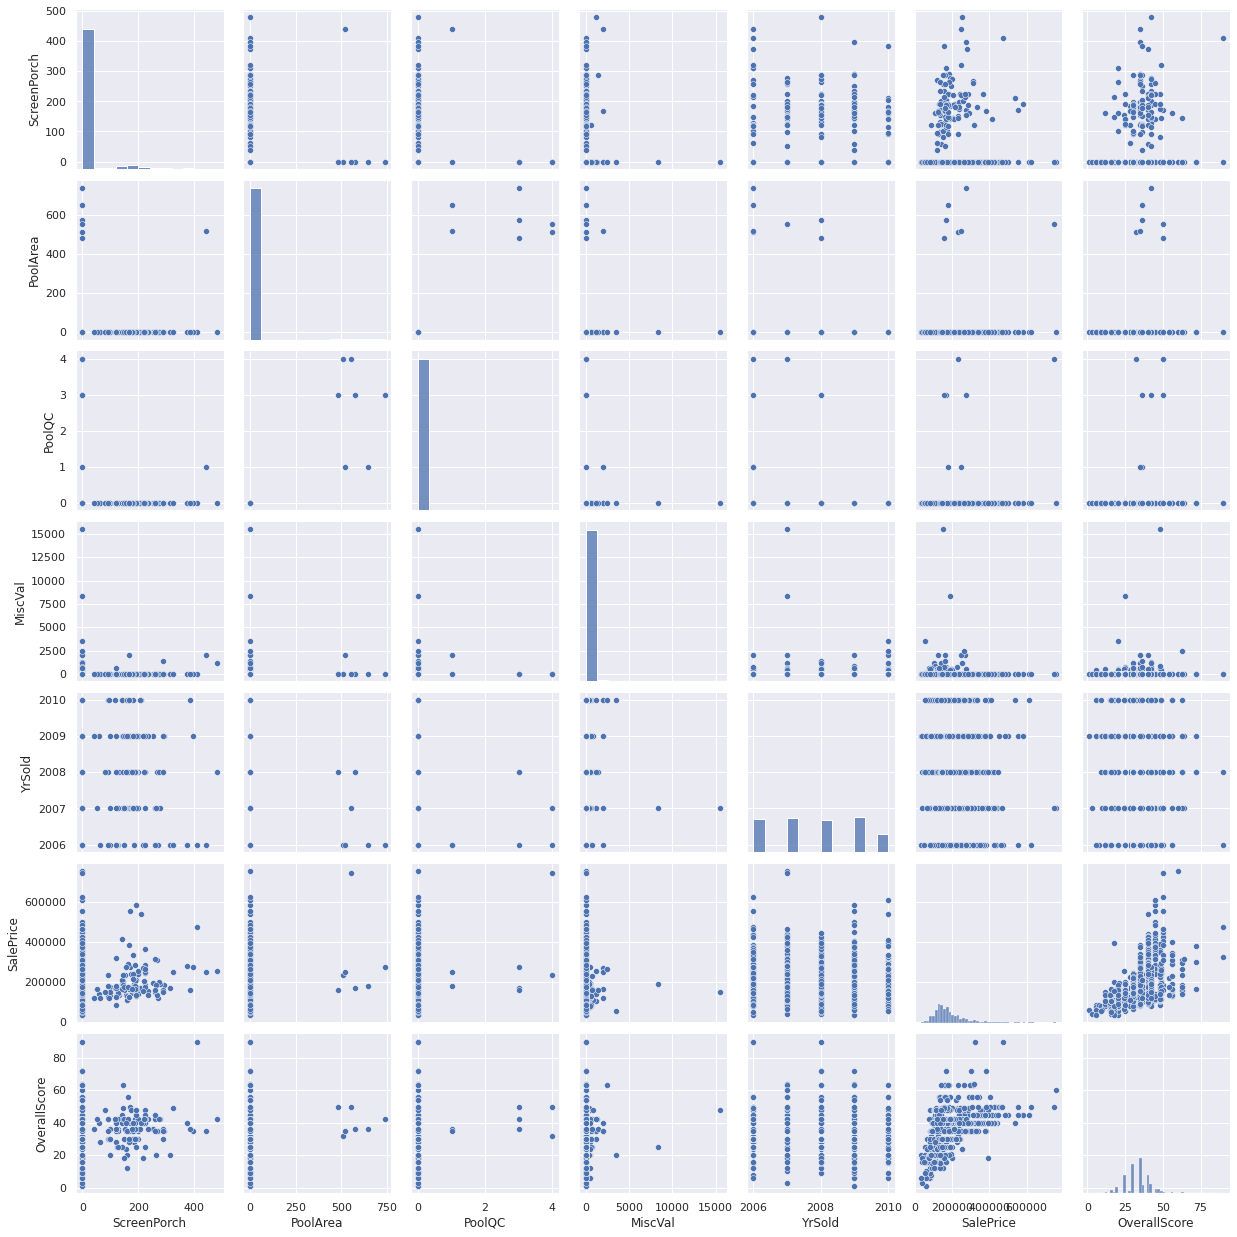

In [43]:
cls=train_num.columns


cols = [x for x in cls]
lcols=len(cols)
for x in range(lcols//7):
    sns.set()
    sns.pairplot(train_num[cols[x*7:min((x+1)*7,lcols)]], size = 2.5)
    plt.show()
    print("\n\n")

## Razão area/numero de quartos

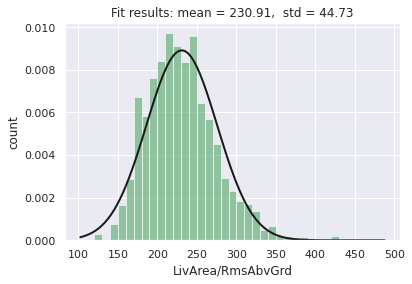

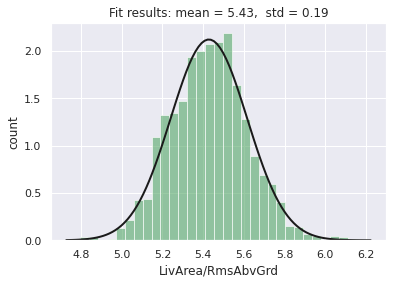

In [44]:
train_num["LivArea/RmsAbvGrd"] = train_num["GrLivArea"] / train_num["TotRmsAbvGrd"]
test_num["LivArea/RmsAbvGrd"] = test_num["GrLivArea"] / test_num["TotRmsAbvGrd"]
plot_histogram(train_num["LivArea/RmsAbvGrd"],dofit=True)
plot_histogram(np.log1p(train_num["LivArea/RmsAbvGrd"]),dofit=True)

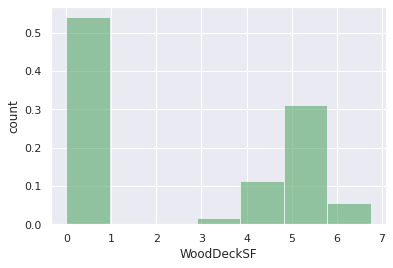

<AxesSubplot:xlabel='HasWoodDeck', ylabel='Count'>

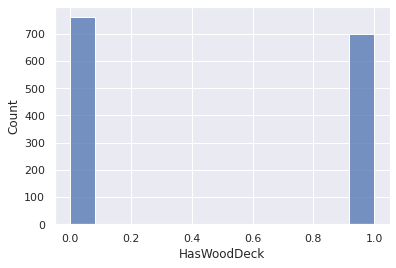

In [45]:
nonnormalfeats=["TotRmsAbvGrd","GarageScore","OverallQual","OverallCond","OverallScore","YrSold","MiscVal","PoolScore","ExterScore","KitchenScore","PoolQC","PoolArea","ScreenPorch","3SsnPorch","GarageYrBlt","KitchenAbvGr",
                "EnclosedPorch","PavedDrive","GarageCond","GarageQual","GarageYrBlt","GarageArea","GarageCars",
                "HalfBath","FullBath","BsmtHalfBath","BsmtFullBath","FireplaceQu","Fireplaces", "Functional",
                "KitchenQual","KitchenAbvGr","BedroomAbvGr","HeatingQC","BsmtFinType2","BsmtFinType1","BsmtExposure",
                 "BsmtCond","BsmtQual","Foundation","ExterCond","ExterQual","YearBuilt","LandSlope","Utilities","LotShape",
                 "Street","BsmtUnfSF","LowQualFinSF","BsmtFinSF2","YearRemodAdd","YearBuilt", "MasVnrArea"]
newfeats={"HasMiscfeat":["MiscVal"],
          "HasPool":["PoolArea","PoolQC"],
          "HasPorch":["ScreenPorch","3SsnPorch","EnclosedPorch","OpenPorchSF"],
          "HasWoodDeck":["WoodDeckSF"],"HasGarage":["GarageArea","GarageCars"], 
          "HasFireplace": ["Fireplaces","FireplaceQu"], "Has2ndFlr": ["2ndFlrSF"],
          "HasBsmt": ["BsmtQual","BsmtCond","TotalBsmtSF","BsmtFinSF2","BsmtFinSF1","BsmtExposure"],
          "HasMasVnr":["MasVnrArea"], "HasFrontage":["LotFrontage"],
         }

for newfeat, feats in newfeats.items():          
    train_cat[newfeat]=train_num.loc[:,feats[0]].apply(lambda x: 1 if x > 0 else 0)
    test_cat[newfeat]=test_num.loc[:,feats[0]].apply(lambda x: 1 if x > 0 else 0)
    
    #for feat in feats:
        #meantrain=train_num.loc[:, feat].mean()
        #meantest=test_num.loc[:, feat].mean()
        #train_num.loc[:, feat] = train_num.loc[:, feat].replace(to_replace = 0, value = np.nan)
        #test_num.loc[:, feat] = test_num.loc[:, feat].replace(to_replace = 0, value = np.nan)
        
plot_histogram(np.log1p(train_num["WoodDeckSF"]))
sns.histplot(train_cat["HasWoodDeck"])

### Variáveis relacionadas aos banheiros da casa

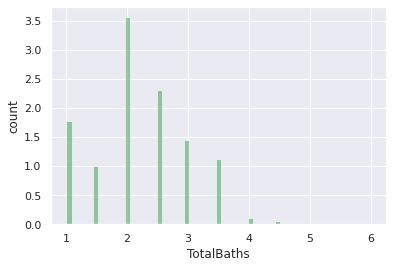

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


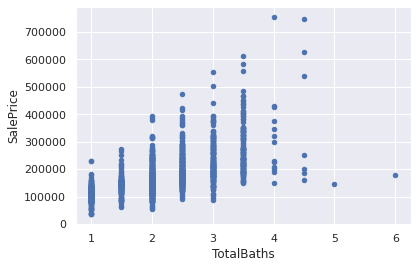

In [46]:
train_num["TotalBaths"] = train_num["BsmtFullBath"] + (0.5 * train_num["BsmtHalfBath"]) + train_num["FullBath"] + (0.5 * train_num["HalfBath"])
test_num["TotalBaths"] = test_num["BsmtFullBath"] + (0.5 * test_num["BsmtHalfBath"]) + test_num["FullBath"] + (0.5 * test_num["HalfBath"])
nonnormalfeats.append("TotalBaths")
plot_histogram(train_num["TotalBaths"])
scatterplot(train_num, "TotalBaths","SalePrice")

### Variáveis relacionadas ao porão (Bsmt)

In [47]:
#train_num["BsmtScore1"]=train_num["BsmtQual"]*train_num["BsmtUnfSF"]/(train_num["BsmtFinSF1"]+train_num["BsmtFinSF2"])
train_num["BsmtScore1"]=(train_num["BsmtQual"]*train_num["BsmtUnfSF"])
test_num["BsmtScore1"]=(test_num["BsmtQual"]*test_num["BsmtUnfSF"])

#train_num["BsmtScore2"]=(train_num["BsmtQual"])*(train_num["BsmtFinSF1"]+train_num["BsmtFinSF2"]-train_num["BsmtUnfSF"])
#test_num["BsmtScore2"]=(test_num["BsmtQual"])*(test_num["BsmtFinSF1"]+test_num["BsmtFinSF2"]-test_num["BsmtUnfSF"])
#train_num["BsmtScore1"].describe()
nonnormalfeats.append("BsmtScore1")

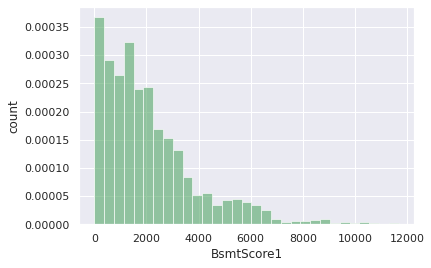

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


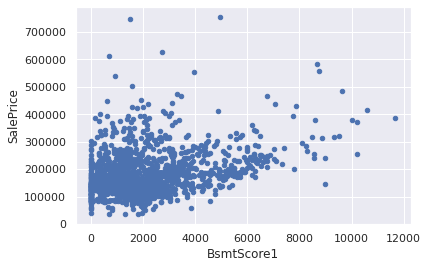

In [48]:
plot_histogram(train_num["BsmtScore1"])
scatterplot(train_num, "BsmtScore1","SalePrice")
#plot_histogram(train_num["BsmtScore2"])
#scatterplot(train_num, "BsmtScore2","SalePrice")

## Algumas features adicionais

In [49]:
#Algumas features adicionais que fazem sentido:
train_num["AllSF"] = train_num["GrLivArea"] + train_num["TotalBsmtSF"]
test_num["AllSF"] = test_num["GrLivArea"] + test_num["TotalBsmtSF"]

train_num["AllFlrsSF"] = train_num["1stFlrSF"] + train_num["2ndFlrSF"]
test_num["AllFlrsSF"] = test_num["1stFlrSF"] + test_num["2ndFlrSF"]

a=["AllSF","AllFlrsSF","BsmtScore2"]

for x in a:
    nonnormalfeats.append(x)

12


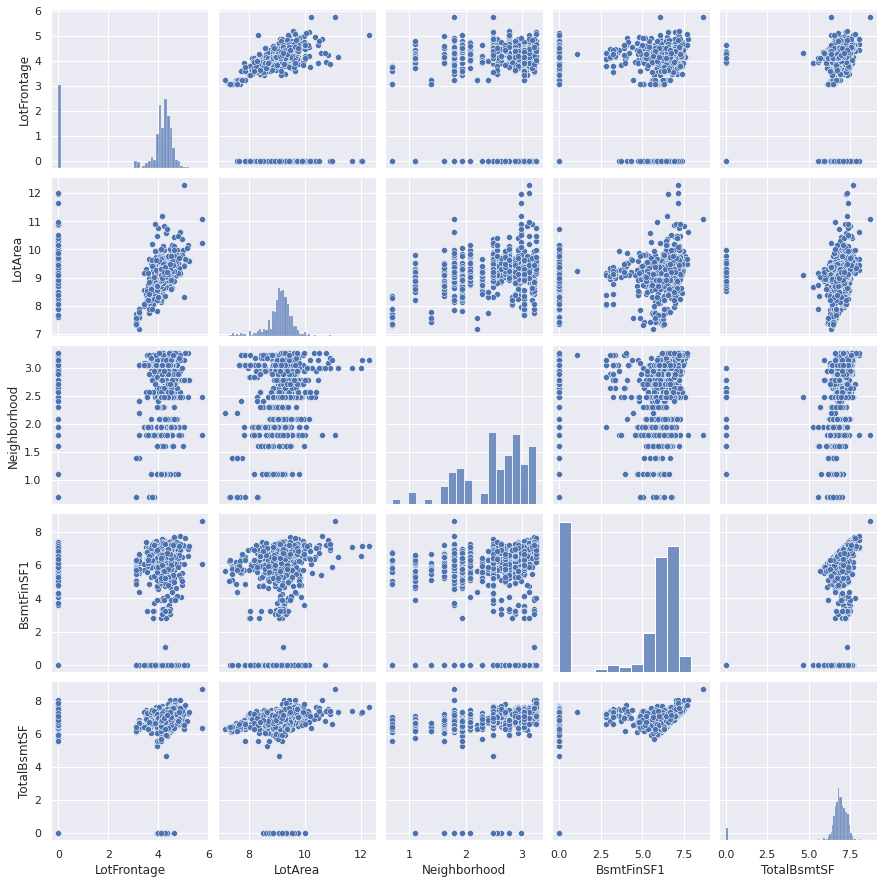

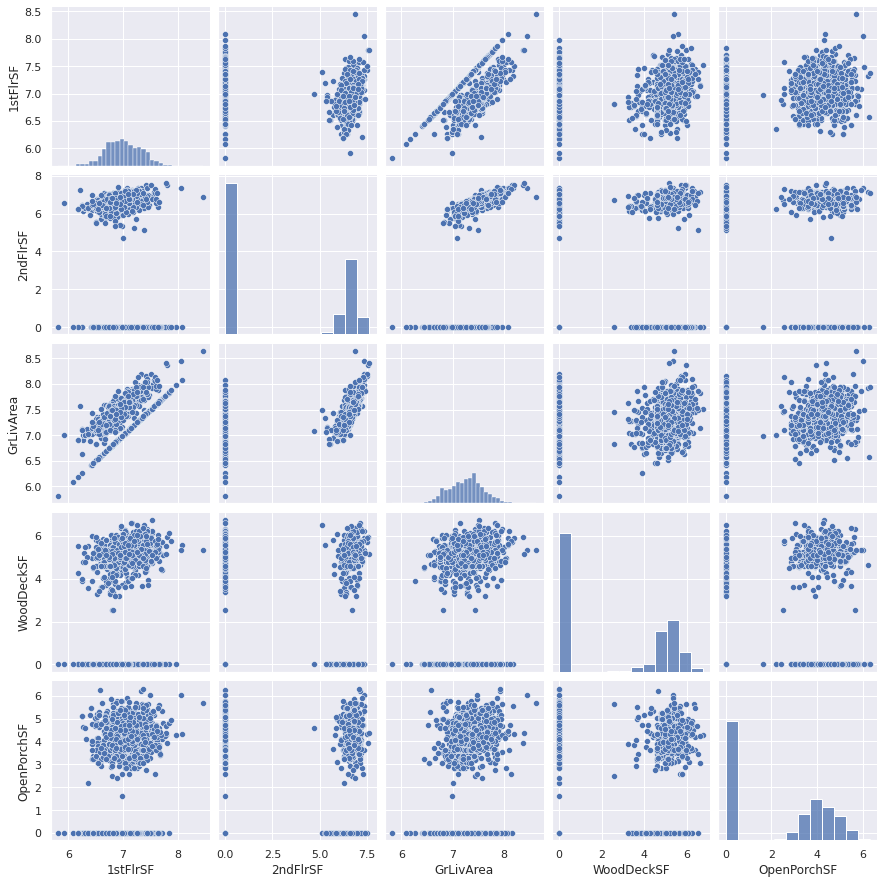

In [50]:
cls=train_num.columns
cols = [x for x in cls if (x not in nonnormalfeats)] #Eliminando as features que não devem seguir uma distribuição normal

#cols = [x for x in cls]
lcols=len(cols)
print(lcols)
for x in range(lcols//5):
    sns.set()
    sns.pairplot(np.log1p(train_num[cols[x*5:min((x+1)*5,lcols)]]), size = 2.5)
    plt.show()
    print("\n\n")

## Aplicando o logarítimo em todas as outras features

In [51]:
cls=train_num.columns
numerical_features=train_num.columns
normalize = [x for x in cls if (x not in nonnormalfeats)]
for feat in normalize:
    train_num[feat]=np.log1p(train_num[feat])
    if (feat != "SalePrice"):
        test_num[feat]=np.log1p(test_num[feat])

# Criando "Dummy Features" para variáveis categóricas

In [52]:
# Criando "Dummy Features" para variáveis categóricas
print("NAs for categorical features in train : " + str(train_cat.isnull().values.sum()))
train_cat = pd.get_dummies(train_cat)

test_cat = pd.get_dummies(test_cat)
traincatcols=train_cat.columns
testcatcols=test_cat.columns
fakefeatures=[]
for x in traincatcols:
    if x not in testcatcols:
        test_cat[x]=0
        fakefeatures.append(x)
#print(fakefeatures)
print("Remaining NAs for categorical features in train : " + str(train_cat.isnull().values.sum()))
categorical_features=train_cat.columns
#train_cat.head(10)

NAs for categorical features in train : 1
Remaining NAs for categorical features in train : 0


In [53]:
# Substituindo os valores que faltam pela mediana
print("NAs for numerical features in train : " + str(train_num.isnull().values.sum()))
train_num = train_num.fillna(train_num.median())
test_num = test_num.fillna(test_num.median())
print("Remaining NAs for numerical features in train : " + str(train_num.isnull().values.sum()))

NAs for numerical features in train : 81
Remaining NAs for numerical features in train : 0


## Padronizando as features

Agora como o problema dos zeros foi resolvido, podemos aplicar a padronização dos dados:

## <center>$x_{pad} =\frac{x-x_{med} }{\sigma} $<center>

In [54]:
#train_num = (train_num-train_num.mean())/(train_num.std())
#test_num = (test_num-test_num.mean())/(test_num.std())
train = pd.concat([train_num, train_cat], axis = 1)
test = pd.concat([test_num, test_cat], axis = 1)

train = (train-train.mean())/(train.std())
test = (test-test.mean())/(test.std())

## Eliminando features problemáticas

In [55]:
#Certas features tem valores que se repetem demais, alguns casos o valor que mais se repete (moda) chega a 
#representar mais de 99% dos dados 
over = []
for i in train.columns:
    counts = train[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(train) * 100 > 70: #90 #65
        over.append(i)


over = list(over)
print(str(len(over))+" Dropped features: "+str(over))
newtrain = train.drop(over, axis=1)
newtest = test.drop(over, axis=1)
newtrain.describe()

191 Dropped features: ['Street', 'LandSlope', 'ExterCond', 'BsmtCond', 'BsmtFinType2', 'BsmtFinSF2', 'LowQualFinSF', 'BsmtHalfBath', 'KitchenAbvGr', 'Functional', 'GarageQual', 'GarageCond', 'PavedDrive', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'MiscVal', 'PoolScore', 'HasMiscfeat', 'HasPool', 'HasPorch', 'HasGarage', 'HasBsmt', 'HasFrontage', 'MSSubClass_SC120', 'MSSubClass_SC160', 'MSSubClass_SC180', 'MSSubClass_SC190', 'MSSubClass_SC30', 'MSSubClass_SC40', 'MSSubClass_SC45', 'MSSubClass_SC50', 'MSSubClass_SC60', 'MSSubClass_SC70', 'MSSubClass_SC75', 'MSSubClass_SC80', 'MSSubClass_SC85', 'MSSubClass_SC90', 'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'Alley_1', 'Alley_2', 'Alley_None', 'LandContour_Bnk', 'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl', 'Utilities_AllPub', 'Utilities_NoSeWa', 'LotConfig_Corner', 'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3', 'LotConfig_Inside', 'Condition1_Artery', 'Conditio

,LotFrontage,LotArea,LotShape,Neighborhood,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,...,HasMasVnr,MSSubClass_SC20,HouseStyle_1Story,HouseStyle_2Story,Exterior1st_VinylSd,Exterior2nd_VinylSd,MasVnrType_BrkFace,MasVnrType_None,GarageType_Attchd,GarageFinish_Unf
count,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,...,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03
mean,1.980684e-15,4.923668e-15,2.231092e-16,-5.868973e-15,2.068361e-16,4.050033e-16,1.066327e-15,4.491004e-15,-1.780919e-16,-3.186188e-16,...,3.204438e-16,-1.587771e-16,2.950456e-17,-2.672140e-16,1.411352e-16,-1.084369e-16,-4.909315e-16,-4.516935e-17,-1.870650e-17,-6.904675e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.112728e+00,-3.749892e+00,-4.450967e+00,-3.205010e+00,-3.687150e+00,-4.111561e+00,-3.286697e+00,-1.688790e+00,-5.705546e-01,-2.430677e+00,...,-8.243945e-01,-7.613733e-01,-9.941948e-01,-6.619089e-01,-7.379704e-01,-7.258344e-01,-6.619089e-01,-1.217365e+00,-1.213905e+00,-8.409029e-01
25%,1.834001e-01,-3.499788e-01,-1.016288e+00,-7.490522e-01,-7.948791e-01,-5.170227e-01,-5.717268e-01,-8.653621e-01,-5.705546e-01,-6.893677e-01,...,-8.243945e-01,-7.613733e-01,-9.941948e-01,-6.619089e-01,-7.379704e-01,-7.258344e-01,-6.619089e-01,-1.217365e+00,-1.213905e+00,-8.409029e-01
50%,4.261767e-01,8.875776e-02,7.010508e-01,2.423627e-01,-7.181151e-02,-5.170227e-01,5.735183e-02,4.424348e-01,-5.705546e-01,-6.893677e-01,...,-8.243945e-01,-7.613733e-01,-9.941948e-01,-6.619089e-01,-7.379704e-01,-7.258344e-01,-6.619089e-01,8.208837e-01,8.232232e-01,-8.409029e-01
75%,5.624008e-01,4.793668e-01,7.010508e-01,6.875912e-01,6.512561e-01,3.816120e-01,9.513056e-01,9.268040e-01,3.382527e-01,1.051942e+00,...,1.212181e+00,1.312517e+00,1.005150e+00,1.509747e+00,1.354140e+00,1.376781e+00,1.509747e+00,8.208837e-01,8.232232e-01,1.188383e+00
max,1.397147e+00,6.124392e+00,7.010508e-01,1.339052e+00,2.820459e+00,3.077516e+00,1.282400e+00,1.217426e+00,8.282363e+00,2.793251e+00,...,1.212181e+00,1.312517e+00,1.005150e+00,1.509747e+00,1.354140e+00,1.376781e+00,1.509747e+00,8.208837e-01,8.232232e-01,1.188383e+00


In [56]:
newtest.describe()

,LotFrontage,LotArea,LotShape,Neighborhood,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,...,MSSubClass_SC150,MSSubClass_SC20,HouseStyle_1Story,HouseStyle_2Story,Exterior1st_VinylSd,Exterior2nd_VinylSd,MasVnrType_BrkFace,MasVnrType_None,GarageType_Attchd,GarageFinish_Unf
count,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,...,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03
mean,-2.632575e-15,2.430646e-14,-2.511128e-17,-5.884030e-16,-4.392191e-16,-1.730396e-16,-1.432865e-16,2.075980e-15,7.178593e-17,1.811056e-17,...,8.066048e-18,-8.400865e-17,-9.740133e-18,-6.011489e-17,-6.708517e-16,-5.904956e-16,3.208156e-16,-4.005630e-16,-5.524482e-17,-5.265760e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.276820e+00,-3.556500e+00,-4.674884e+00,-3.044410e+00,-3.534786e+00,-4.088751e+00,-3.039077e+00,-1.593092e+00,-5.631228e-01,-2.383060e+00,...,-2.618016e-02,-7.696678e-01,-1.021128e+00,-6.430211e-01,-7.328298e-01,-7.328298e-01,-6.504801e-01,-1.257464e+00,-1.186013e+00,-8.653825e-01
25%,1.754523e-01,-3.400791e-01,-1.089783e+00,-6.726367e-01,-7.508438e-01,-4.972473e-01,-6.040716e-01,-9.778668e-01,-5.631228e-01,-6.778691e-01,...,-2.618016e-02,-7.696678e-01,-1.021128e+00,-6.430211e-01,-7.328298e-01,-7.328298e-01,-6.504801e-01,-1.257464e+00,-1.186013e+00,-8.653825e-01
50%,4.023547e-01,1.386843e-01,7.027684e-01,1.580056e-01,-5.485835e-02,-4.972473e-01,5.403807e-02,3.945591e-01,-5.631228e-01,-6.778691e-01,...,-2.618016e-02,-7.696678e-01,9.786380e-01,-6.430211e-01,-7.328298e-01,-7.328298e-01,-6.504801e-01,7.947062e-01,8.425834e-01,-8.653825e-01
75%,5.380016e-01,5.436012e-01,7.027684e-01,7.147621e-01,6.411271e-01,4.006287e-01,9.753916e-01,9.624594e-01,3.521221e-01,1.027322e+00,...,-2.618016e-02,1.298371e+00,9.786380e-01,1.554093e+00,1.363638e+00,1.363638e+00,1.536272e+00,7.947062e-01,8.425834e-01,1.154766e+00
max,1.139597e+00,3.715427e+00,7.027684e-01,1.343893e+00,2.729083e+00,3.094257e+00,1.271541e+00,1.246410e+00,6.724939e+00,2.732514e+00,...,3.817068e+01,1.298371e+00,9.786380e-01,1.554093e+00,1.363638e+00,1.363638e+00,1.536272e+00,7.947062e-01,8.425834e-01,1.154766e+00


In [57]:
#plot_histogram(df_train["TotalBsmtSF"])
#plot_histogram(df_test["TotalBsmtSF"])
#plot_histogram(newtrain["TotalBsmtSF"])
#plot_histogram(newtest["TotalBsmtSF"])

## 3$^a$ Regressão

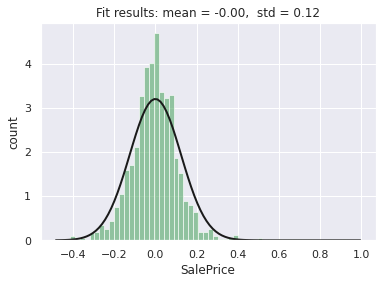

R2score: 0.9040865520064387
RMSE on Training set : 0.1387724862658271
RMSE on Validation set : 0.14239421707243224


count    1.314000e+03
mean    -7.448802e-16
std      1.246806e-01
min     -4.162671e-01
25%     -6.841332e-02
50%     -4.131087e-03
75%      6.361274e-02
max      9.289640e-01
Name: SalePrice, dtype: float64

In [58]:
features = newtrain.columns.drop("SalePrice") 
#print(features)
X_train, X_valid, y_train, y_valid = train_test_split(newtrain[features], target, test_size = 0.1, random_state = 0)


lr = LinearRegression()
lr.fit(X_train, y_train)
y_train_pred = lr.predict(X_train)
y_valid_pred = lr.predict(X_valid)
error = y_train_pred - y_train

plot_histogram(error, dofit=True)
print("R2score: "+ str(lr.score(X_train, y_train)))
print("RMSE on Training set :", rmse_cv_train(lr,X_train,y_train).mean())
print("RMSE on Validation set :", rmse_cv_test(lr,X_valid,y_valid).mean())
error.describe()

In [59]:
trainprices=(lr.predict(X_train))
X_train["SalePrices"]=np.exp(trainprices)
testSalePrices=(lr.predict(newtest[features]))
newtest["SalePrices"]=np.exp(testSalePrices)

In [60]:
np.exp(target).describe()

count      1460.000000
mean     180922.195890
std       79442.502883
min       34901.000000
25%      129976.000000
50%      163001.000000
75%      214001.000000
max      755001.000000
Name: SalePrice, dtype: float64

In [61]:
newtest["SalePrices"].describe()

count      1459.000000
mean     178787.374426
std       69977.915785
min       51227.875211
25%      129084.183881
50%      163856.261586
75%      213949.030301
max      457096.529969
Name: SalePrices, dtype: float64

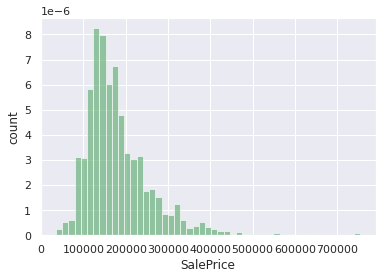

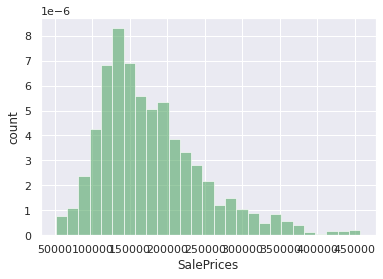

In [62]:
plot_histogram(np.exp(target))
plot_histogram((newtest["SalePrices"]))

In [63]:
result=pd.DataFrame(testids)
result["SalePrice"]=newtest["SalePrices"]

In [64]:
#result.to_csv("./result10(50cut).csv",index=False)